In [1]:
from typing import Optional, Tuple, Dict, List, Sequence, Any
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from rdkit import DataStructs
from openbabel import pybel
import py3Dmol

p_features = pd.read_csv('../data/pi_qsar_features.csv')
p_cols = pd.read_csv('../artifacts/protease_features.csv')
p_cols.head()

,0
0,MolWt
1,MolLogP
2,TPSA
3,NumHDonors
4,NumHAcceptors


In [2]:
p_features.shape

(834, 523)

In [3]:
smiles = 'CC(=O)Oc1ccccc1C(=O)O'

In [78]:
def mol_from_smiles_safe(smi: str) -> Optional[Chem.Mol]:
    """
    Return RDKit Mol for a SMILES string or None if parsing fails.
    Accepts None / NaN inputs safely.
    """
    if smi is None:
        return None
    # handle NaN floats
    if isinstance(smi, float) and np.isnan(smi):
        return None
    try:
        m = Chem.MolFromSmiles(str(smi))
        return m
    except Exception:
        return None

In [79]:
DEFAULT_DESC_LIST = [
    'MolWt', 'MolLogP', 'MolMR', 'TPSA', 'NumHDonors', 'NumHAcceptors',
    'NumRotatableBonds', 'NumAromaticRings', 'HeavyAtomCount', 'FractionCSP3'
]

In [80]:
def compute_descriptors_for_mol(m: Chem.Mol) -> Dict[str, float]:
    """Compute a set of basic 2D descriptors for a single RDKit Mol."""
    if m is None:
        return {k: np.nan for k in DEFAULT_DESC_LIST}
    try:
        molwt = Descriptors.MolWt(m)
        logp, mr = rdMolDescriptors.CalcCrippenDescriptors(m)
        tpsa = rdMolDescriptors.CalcTPSA(m)
        hbd = rdMolDescriptors.CalcNumHBD(m)
        hba = rdMolDescriptors.CalcNumHBA(m)
        rot = rdMolDescriptors.CalcNumRotatableBonds(m)
        arom = rdMolDescriptors.CalcNumAromaticRings(m)
        hac = Descriptors.HeavyAtomCount(m)
        fsp3 = rdMolDescriptors.CalcFractionCSP3(m)
        return {
            'MolWt': float(molwt),
            'MolLogP': float(logp),
            'MolMR': float(mr),
            'TPSA': float(tpsa),
            'NumHDonors': int(hbd),
            'NumHAcceptors': int(hba),
            'NumRotatableBonds': int(rot),
            'NumAromaticRings': int(arom),
            'HeavyAtomCount': int(hac),
            'FractionCSP3': float(fsp3)
        }
    except Exception:
        return {k: np.nan for k in DEFAULT_DESC_LIST}
    
def morgan_fp_array(m: Chem.Mol, radius: int = 2, nBits: int = 2048) -> np.ndarray:
    """Return numpy array (0/1 int) of Morgan fingerprint for a single RDKit Mol."""
    if m is None:
        return np.zeros((nBits,), dtype=np.uint8)
    try:
        bitvect = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nBits)
        arr = np.zeros((nBits,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(bitvect, arr)
        return arr
    except Exception:
        return np.zeros((nBits,), dtype=np.uint8)
    
def fp_array_to_df(fp_arr: np.array, prefix: str = 'Morgan') -> pd.DataFrame:
    """Convert morgan fingerprint array into dataframe of shape (n_samples, nBits)"""
    nBits = fp_arr.shape[0]
    cols = [f'{prefix}_{i}' for i in range(nBits)]
    return pd.DataFrame([fp_arr], columns=cols)

In [81]:
m = mol_from_smiles_safe(smiles)
desc = compute_descriptors_for_mol(m)
morgan = morgan_fp_array(m, nBits=512)
morgan_df = fp_array_to_df(morgan, prefix = 'Morgan_512')

In [103]:
p_features.head()

,MolWt,MolLogP,MolMR,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,HeavyAtomCount,FractionCSP3,...,Morgan_512_503,Morgan_512_504,Morgan_512_505,Morgan_512_506,Morgan_512_507,Morgan_512_508,Morgan_512_509,Morgan_512_510,Morgan_512_511,pIC50
0,636.814,4.00190,179.2214,121.72,4,5,12,4,46,0.315789,...,0,0,0,0,1,0,0,0,0,7.675718
1,623.775,3.80477,172.8031,145.57,5,6,10,4,45,0.277778,...,0,0,0,0,1,0,0,0,0,6.812761
2,623.775,3.80477,172.8031,145.57,5,6,10,4,45,0.277778,...,0,0,0,0,1,0,0,0,0,7.428291
3,651.829,4.29997,181.9411,145.57,5,6,12,4,47,0.315789,...,0,0,0,0,1,0,0,0,0,8.602060
4,636.814,4.00190,179.2214,121.72,4,5,12,4,46,0.315789,...,0,0,0,0,1,0,0,0,0,5.000000


In [82]:
desc

{'MolWt': 180.15899999999996,
 'MolLogP': 1.3101,
 'MolMR': 44.71030000000002,
 'TPSA': 63.60000000000001,
 'NumHDonors': 1,
 'NumHAcceptors': 3,
 'NumRotatableBonds': 2,
 'NumAromaticRings': 1,
 'HeavyAtomCount': 13,
 'FractionCSP3': 0.1111111111111111}

In [83]:
morgan.shape[0]

512

In [84]:
morgan_df

,Morgan_512_0,Morgan_512_1,Morgan_512_2,Morgan_512_3,Morgan_512_4,Morgan_512_5,Morgan_512_6,Morgan_512_7,Morgan_512_8,Morgan_512_9,...,Morgan_512_502,Morgan_512_503,Morgan_512_504,Morgan_512_505,Morgan_512_506,Morgan_512_507,Morgan_512_508,Morgan_512_509,Morgan_512_510,Morgan_512_511
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [85]:
desc_df = pd.DataFrame([desc])
desc_df

,MolWt,MolLogP,MolMR,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,HeavyAtomCount,FractionCSP3
0,180.159,1.3101,44.7103,63.6,1,3,2,1,13,0.111111


In [97]:
def build_feature_df(smiles: str, morgan_radius: int = 2, nBits: int = 1024) -> pd.DataFrame:
    '''For a given smiles, construct its feature dataframe having molecular descriptors and fingerprints.'''
    m = mol_from_smiles_safe(smiles)
    desc = compute_descriptors_for_mol(m)
    desc_df = pd.DataFrame([desc])
    morgan = morgan_fp_array(m, nBits=512)
    morgan_df = fp_array_to_df(morgan, prefix = f'Morgan_{nBits}')
    features = pd.concat([desc_df.reset_index(drop=True), morgan_df.reset_index(drop=True)], axis=1)
    return features

In [98]:
f = build_feature_df(smiles, nBits=512)
f.shape

(1, 522)

In [99]:
p_cols.shape

(519, 1)

In [100]:
p_actual_cols = p_cols.iloc[:, 0].tolist()
len(p_actual_cols)

519

In [101]:
f.columns

Index(['MolWt', 'MolLogP', 'MolMR', 'TPSA', 'NumHDonors', 'NumHAcceptors',
       'NumRotatableBonds', 'NumAromaticRings', 'HeavyAtomCount',
       'FractionCSP3',
       ...
       'Morgan_512_502', 'Morgan_512_503', 'Morgan_512_504', 'Morgan_512_505',
       'Morgan_512_506', 'Morgan_512_507', 'Morgan_512_508', 'Morgan_512_509',
       'Morgan_512_510', 'Morgan_512_511'],
      dtype='object', length=522)

In [91]:
p_actual_cols

['MolWt',
 'MolLogP',
 'TPSA',
 'NumHDonors',
 'NumHAcceptors',
 'NumRotatableBonds',
 'NumAromaticRings',
 'FractionCSP3',
 'Morgan_512_0',
 'Morgan_512_1',
 'Morgan_512_2',
 'Morgan_512_3',
 'Morgan_512_4',
 'Morgan_512_5',
 'Morgan_512_6',
 'Morgan_512_7',
 'Morgan_512_8',
 'Morgan_512_9',
 'Morgan_512_10',
 'Morgan_512_11',
 'Morgan_512_12',
 'Morgan_512_13',
 'Morgan_512_14',
 'Morgan_512_15',
 'Morgan_512_16',
 'Morgan_512_17',
 'Morgan_512_18',
 'Morgan_512_19',
 'Morgan_512_20',
 'Morgan_512_21',
 'Morgan_512_22',
 'Morgan_512_23',
 'Morgan_512_24',
 'Morgan_512_25',
 'Morgan_512_26',
 'Morgan_512_27',
 'Morgan_512_28',
 'Morgan_512_29',
 'Morgan_512_30',
 'Morgan_512_31',
 'Morgan_512_32',
 'Morgan_512_33',
 'Morgan_512_34',
 'Morgan_512_35',
 'Morgan_512_36',
 'Morgan_512_37',
 'Morgan_512_38',
 'Morgan_512_39',
 'Morgan_512_40',
 'Morgan_512_41',
 'Morgan_512_42',
 'Morgan_512_43',
 'Morgan_512_44',
 'Morgan_512_45',
 'Morgan_512_46',
 'Morgan_512_47',
 'Morgan_512_48',
 'Mo

In [92]:
def select_actual_columns(x: pd.DataFrame, expected_cols: List[str]) -> pd.DataFrame:
    """
    Remove columns not used during training and ensure the same column order as expected_cols.
    """
    # Keep only the expected columns that actually exist in x
    actual_cols = [c for c in expected_cols if c in x.columns]
    # Select and reorder columns
    x_new = x[actual_cols].copy()
    return x_new

In [93]:
f = select_actual_columns(f, p_actual_cols)
f.shape

(1, 519)

In [94]:
f.columns

Index(['MolWt', 'MolLogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
       'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3', 'Morgan_512_0',
       'Morgan_512_1',
       ...
       'Morgan_512_502', 'Morgan_512_503', 'Morgan_512_504', 'Morgan_512_505',
       'Morgan_512_506', 'Morgan_512_507', 'Morgan_512_508', 'Morgan_512_509',
       'Morgan_512_510', 'Morgan_512_511'],
      dtype='object', length=519)

In [61]:
import joblib
import os
MODEL_DIR = "../models"
PROTEASE_MODELS = {
    "svm": os.path.join(MODEL_DIR, "pi_svm.joblib"),
    "knn": os.path.join(MODEL_DIR, "pi_knn.joblib"),
    "rf": os.path.join(MODEL_DIR, "pi_rf.joblib"),
    "ensembler": os.path.join(MODEL_DIR, "pi_meta.joblib")
}
INTEGRAE_MODELS = {
    "svm": os.path.join(MODEL_DIR, "ii_svm.joblib"),
    "knn": os.path.join(MODEL_DIR, "ii_knn.joblib"),
    "rf": os.path.join(MODEL_DIR, "ii_rf.joblib"),
    "ensembler": os.path.join(MODEL_DIR, "ii_meta.joblib")
}

def load_model(path):
    if not os.path.exists(path):
        return None
    return joblib.load(path)

# load models lazily
protease_models = {name: load_model(p) for name, p in PROTEASE_MODELS.items()}
integrase_models = {name: load_model(p) for name, p in INTEGRAE_MODELS.items()}

In [69]:
svm_out = protease_models['svm'].predict(f)[0]
rf_out = protease_models['rf'].predict(f)[0]
knn_out = protease_models['knn'].predict(f)[0]
meta_in = [[knn_out, svm_out, rf_out]]
meta_out = protease_models['ensembler'].predict(meta_in)

In [75]:
meta_out[0]

np.float64(4.096915382768704)

In [106]:
import re
from sklearn.metrics import pairwise_distances

def check_applicability_knn(
    X_train: pd.DataFrame,
    x_new: pd.DataFrame,
    k: int = 5,
    threshold: float = 0.25,
    fp_prefixes: str = 'Morgan'
) -> Tuple[bool, float]:
    """
    kNN Jaccard AD check using fingerprint columns.

    - X_train: DataFrame containing training data (may contain descriptors and fingerprint columns).
    - x_new: either a single-row DataFrame (preferred), a Series, or a 1D numpy array with the same fingerprint columns.
    - k: number of nearest neighbours to average.
    - threshold: maximum average Jaccard distance to be considered 'within AD' (default 0.25).
    - fp_prefixes: iterable of common prefixes used to recognise fingerprint columns.

    Returns:
      (in_ad_bool, avg_jaccard_distance)

    Notes:
    - The function looks for fingerprint columns by matching column names that start with any prefix
      in fp_prefixes (case-sensitive for prefixes provided; common prefixes included by default).
    - If fewer than k training rows exist, k is reduced to n_train.
    """
    X_train = X_train.drop(columns=['pIC50'], axis=1)

    # find fingerprint columns in X_train using prefixes (regex for safety)
    pattern = re.compile(rf"^({'|'.join([re.escape(p) for p in fp_prefixes])})")
    fp_cols = [c for c in X_train.columns if pattern.match(c)]

    if len(fp_cols) == 0:
        # no obvious fingerprint columns found — raise so user can decide what to do
        raise ValueError(
            "No fingerprint columns found in X_train. "
            f"Looked for prefixes: {tuple(fp_prefixes)}. "
            "If your Morgan columns use a different prefix, pass it via `fp_prefixes`."
        )

    # align x_row with fingerprint columns
    x_row = x_new.iloc[0]
    # Series or DataFrame row: ensure columns present
    missing = [c for c in fp_cols if c not in x_row.index]
    if missing:
        raise ValueError(f"x_new is missing fingerprint columns: {missing}")
    x_fp = x_row[fp_cols].values

    # prepare boolean arrays for Jaccard
    X_fp_matrix = X_train[fp_cols].astype(bool).values
    x_fp_vector = np.asarray(x_fp).astype(bool).reshape(1, -1)

    # adjust k if necessary
    n_train = X_fp_matrix.shape[0]
    if n_train == 0:
        raise ValueError("X_train contains zero rows.")
    if k > n_train:
        k = n_train

    # compute Jaccard distances
    dists = pairwise_distances(X_fp_matrix, x_fp_vector, metric="jaccard").flatten()
    nearest = np.sort(dists)[:k]
    avg = float(np.mean(nearest))

    return (avg <= threshold, avg)

In [107]:
is_ad, avg = check_applicability_knn(p_features, f)

In [108]:
is_ad

False

In [109]:
avg

0.6844067680263596

In [114]:
import matplotlib.pyplot as plt
def make_williams_plot(df: pd.DataFrame):
    """
    Simple Williams plot:
      - X: leverage (h)
      - Y: standardized residuals
    df should contain descriptor columns and 'pIC50' as target.
    """
    if 'pIC50' not in df.columns:
        raise ValueError("df must contain 'pIC50' column for Williams plot.")
    # split
    X = df.drop(columns=['pIC50']).values
    y = df['pIC50'].values
    # linear fit for residuals (ordinary least squares)
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])  # intercept
    beta = np.linalg.pinv(X_design.T @ X_design) @ X_design.T @ y
    y_pred = X_design @ beta
    residuals = y - y_pred
    mse = np.mean(residuals**2)
    std_resid = residuals / np.sqrt(mse)
    # leverages
    H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
    leverages = np.diag(H)
    h_star = 3 * (X_design.shape[1]) / X_design.shape[0]

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(leverages, std_resid, alpha=0.7)
    ax.axvline(h_star, color='red', linestyle='--', label=f"h* = {h_star:.3f}")
    ax.axhline(3, color='orange', linestyle='--')
    ax.axhline(-3, color='orange', linestyle='--')
    ax.set_xlabel("Leverage (h)")
    ax.set_ylabel("Standardized residuals")
    ax.set_title("Williams plot")
    # Legend in top-right inside the plot
    ax.legend(loc='upper right', fontsize='small', framealpha=0.85)
    fig.tight_layout()
    return fig

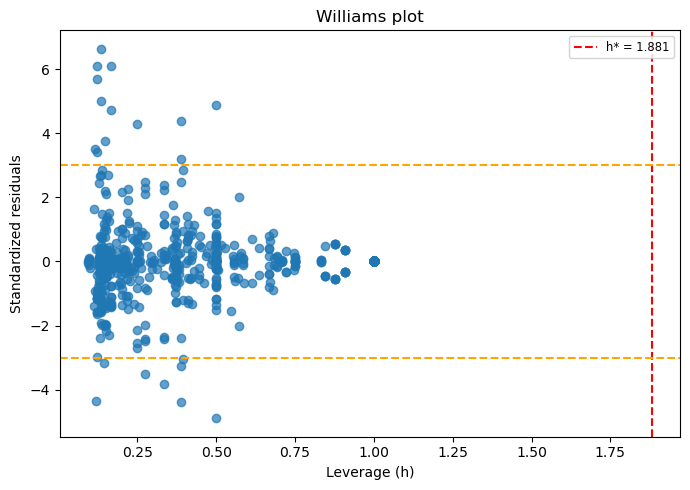

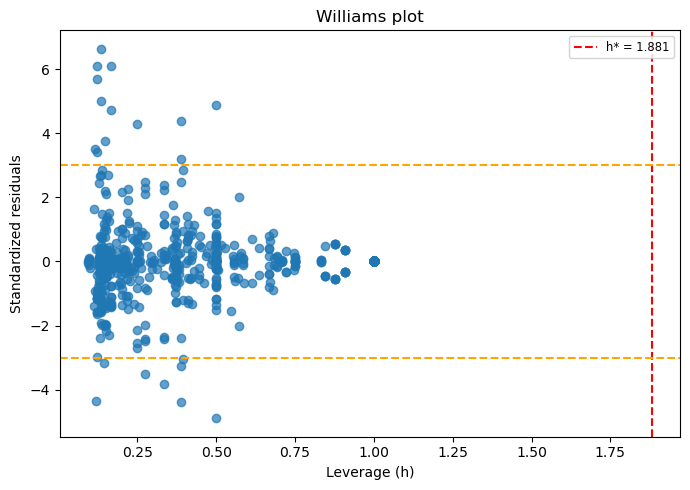

In [115]:
make_williams_plot(p_features)

In [6]:
ii = pd.read_csv('../data/ii_qsar_features.csv')
# make_williams_plot(ii)

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re

def _get_fp_matrix(df: pd.DataFrame, fp_prefixes='Morgan') -> (np.ndarray, list):
    """
    Return boolean fingerprint matrix (n_samples, n_bits) and the ordered list of fp column names.
    Raises if no fingerprint columns found.
    """
    pattern = re.compile(rf"^({'|'.join([re.escape(p) for p in fp_prefixes])})")
    fp_cols = [c for c in df.columns if pattern.match(c)]
    if len(fp_cols) == 0:
        raise ValueError(f"No fingerprint columns found. Looked for prefixes: {fp_prefixes}")
    # Convert to bool (0/1 -> False/True). Keep dtype int if you prefer.
    M = df[fp_cols].fillna(0).astype(bool).values
    return M, fp_cols

def tanimoto_matrix_from_bool(M: np.ndarray) -> np.ndarray:
    """
    Input:
      M: boolean array shape (n_samples, n_bits)
    Returns:
      S: float similarity matrix shape (n_samples, n_samples) with values in [0,1]
    Note: O(n^2 * n_bits) memory/time. Use only for n up to a few thousand (depending on memory).
    """
    # compute pairwise Jaccard distances with sklearn, then convert
    # pairwise_distances returns distances in [0,1], where distance = 1 - similarity for boolean Jaccard
    dists = pairwise_distances(M, M, metric="jaccard")  # symmetric
    S = 1.0 - dists
    # fill diagonal with 1.0 for numerical stability
    np.fill_diagonal(S, 1.0)
    return S

def plot_similarity_heatmap(S: np.ndarray, labels=None, subset=None, use_plotly=False, figsize=(8,8)):
    """
    S: similarity matrix (n_samples, n_samples)
    subset: optional list/array of row indices to show (e.g. np.random.choice(n, 100, replace=False))
    labels: optional tick labels (must match subset length)
    """
    if subset is not None:
        S_sub = S[np.ix_(subset, subset)]
        ticks = labels and [labels[i] for i in subset] or None
    else:
        S_sub = S
        ticks = labels

    if use_plotly:
        fig = px.imshow(S_sub, color_continuous_scale='Viridis', labels=dict(x="Molecule", y="Molecule", color="Tanimoto"))
        fig.update_layout(width=800, height=800)
        return fig
    else:
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(S_sub, vmin=0, vmax=1, cmap="viridis", ax=ax, cbar_kws={'label': 'Tanimoto'})
        if ticks:
            ax.set_xticks(np.arange(len(ticks))+0.5)
            ax.set_xticklabels(ticks, rotation=90, fontsize=6)
            ax.set_yticks(np.arange(len(ticks))+0.5)
            ax.set_yticklabels(ticks, rotation=0, fontsize=6)
        ax.set_title("Tanimoto similarity heatmap")
        fig.tight_layout()
        return fig

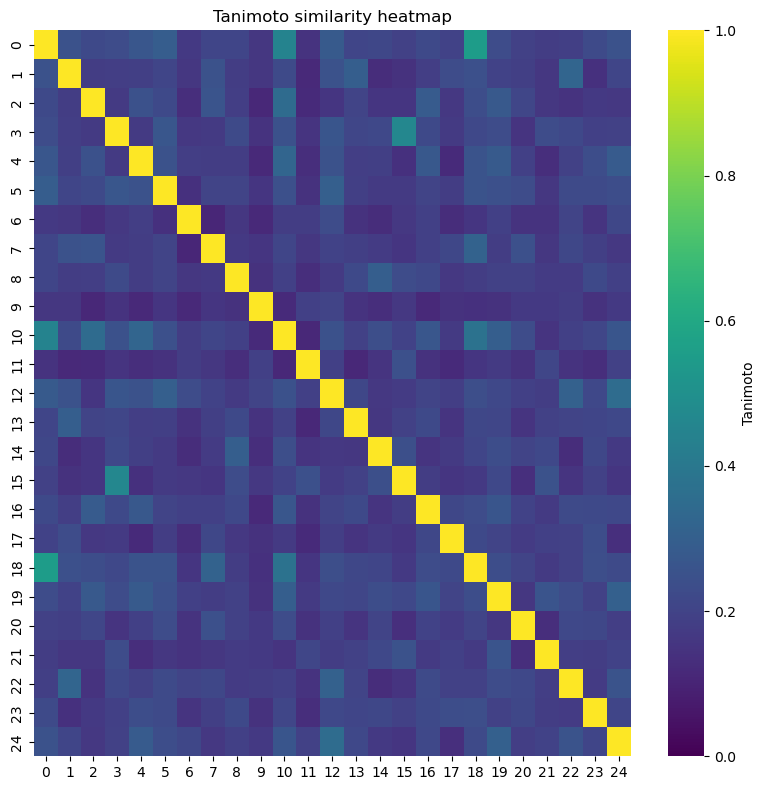

In [11]:
M, cols = _get_fp_matrix(ii)
S = tanimoto_matrix_from_bool(M)
# choose 80 molecules to visualize:
idx = np.random.choice(S.shape[0], size=min(25, S.shape[0]), replace=False)
fig = plot_similarity_heatmap(S, subset=idx)
plt.show()   # or in Streamlit: st.pyplot(fig)

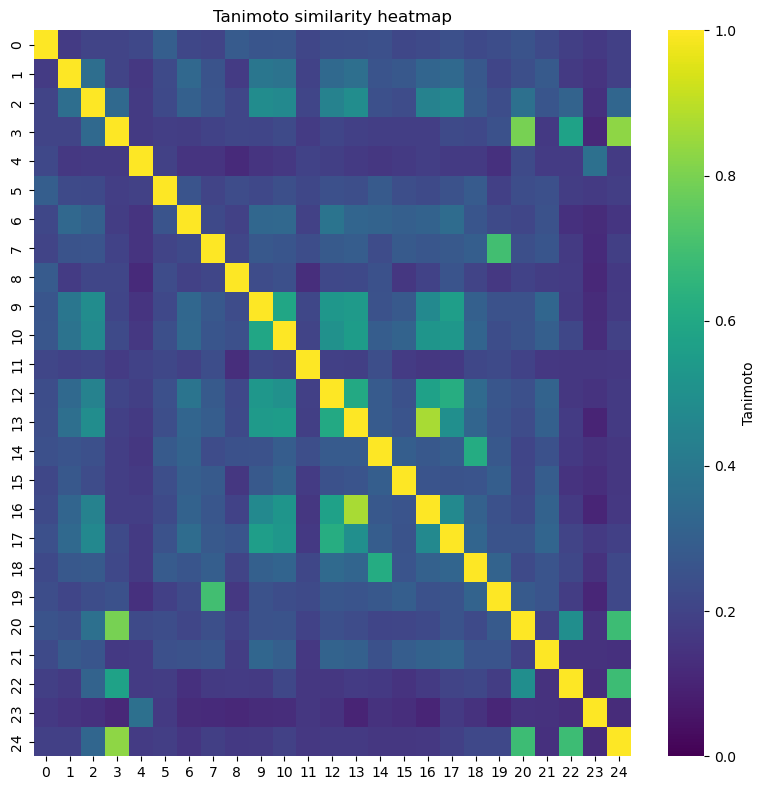

In [12]:
M, cols = _get_fp_matrix(p_features)
S = tanimoto_matrix_from_bool(M)
# choose 80 molecules to visualize:
idx = np.random.choice(S.shape[0], size=min(25, S.shape[0]), replace=False)
fig = plot_similarity_heatmap(S, subset=idx)
plt.show()   # or in Streamlit: st.pyplot(fig)